# 5-Droupout 과 Batch Normalization

- 딥러닝의 세계는 생각보다 더 복잡함
- 모델에 추가할 수 있는 레이어에는 수십 종류가 있고, 이 중 때때로 다양한 방식으로 모델에 도움이 될 수 있는 일부 기능을 추가하는 두 가지 종류의 특수 레이어를 설명하고자 함

## Dropout

- 4장에서 훈련 데이터에서 네트워크 학습으로 과적합이 어떻게 발생하는지 배웠는데, 이를 방지하기 위해서 가중치의 특정조합에 의존하는 방식이다. 
- 즉 훈련의 모든 단계에서 layer의 입력 단위의 일부를 무작위로 삭제하여 네트워크가 훈련 데이터에서 이러한 가짜 패턴을 학습시키는 것을 더 어렵게 만든다. 
- 이는 가중치 패턴이 더 강력한 경향이 있는 광범위하고 일반적인 패턴을 찾게끔 해줌!!


- 해당 그림은 dropout을 50%로 설정하였을 때, 50%의 확률인 2개를 무시하고 2개만 학습함 (이는 학습시 계속 무작위로 설정됨)
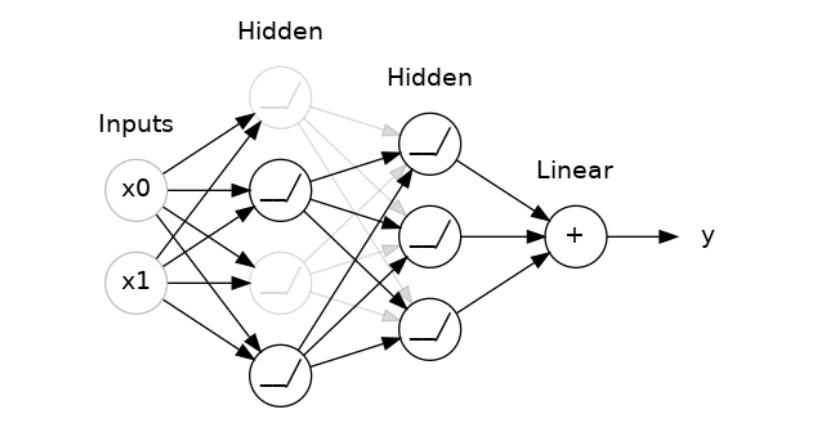

## Batch Normalization

- 배치 정규화는 느리거나 불안정한 훈련을 올바르게 하는데 도움이 된다.
- **뉴럴 네트워크를 구축할때, StandardScaler 또는 MinMaxScaler 처럼 모든 데이터를 공통 규모로 배치하는 것이 좋다.**
    - 그 이유는 SGD가 데이터가 생성하는 활성화의 크기에 비례하여 네트워크 가중치를 이동시키기 때문이다.
    - 매우 다른 크기의 활성화를 생성하는 경향이 있는 기능은 불안정한 훈련 동작을 만듬!!
   
   
- 네트워크에 들어가기 전에 정규화 하는 것이 좋다면, 네트워크 내부에서도 정규화하는 것이 더 좋을 것이다.
- 이를 해주는 역할이 Batch Normalization layer이다.
    1. 각 배치가 들어오는대로 살펴보고 먼저, 그것의 mean과 standard deviation으로 배치를 정규화한다.
    2. 그 다음 두 개의 학습 가능한 크기의 rescaling parameter를 사용하여 데이터를 새로운 크기에 추가한다.
    3. 실제로 Batchnorm은 입력에 대해 일종의 크기 조정을 수행한다.
    

- 대부분 최적화 프로세스에 대한 지원으로 추가됨(예측성능에도도움 될 수 있음)
- batchnorm이 있는 모델은 훈련을 완료하는데 더 적은 epoch가 필요한 경향이 있다!!

#### 실습1

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('data/spotify.csv')

# 4장에서 진행하였던 전처리
X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


#### dropout을 추가한 모델 구축

In [3]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

Minimum Validation Loss: 0.1922


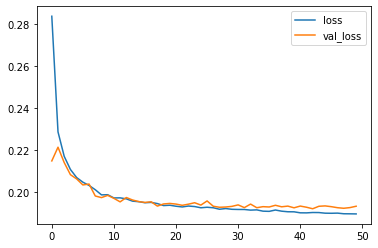

In [4]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

#### 결과

- train loss가 계속 감소하더라도 valid loss도 계속 최소값에 가까운 것을 확인가능!!
- 즉 과적합을 방지했음을 확인 할 수 있다.(4장의 결과와 비교해보아도 차이가 남!!)

#### 실습2

In [5]:
import pandas as pd

concrete = pd.read_csv('data/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0) #frac만큼 sample뽑음
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

Epoch 1/100
12/12 [==============================] - 0s 15ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/100
12/12 [============================

12/12 [==============================] - 0s 9ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 70/100
12/12 [==============================] - 0s 8ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 71/100
12/12 [==============================] - 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 72/100
12/12 [==============================] - 0s 8ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 73/100
12/12 [==============================] - 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 74/100
12/12 [==============================] - 0s 5ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 75/100
12/12 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 76/100
12/12 [==============================] - 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 77/100
12/12 [==============================] -

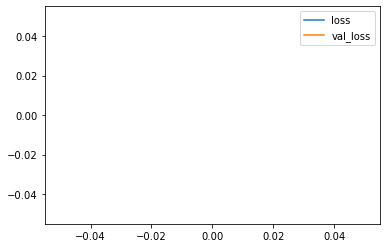

In [7]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', 
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=1,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

- 해당 데이터셋은 실패!! 왜??

- Batch normalization layer가 도와줄 것이다

- **batch normalization layer 1층 추가**

In [10]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
#     layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
#     layers.BatchNormalization(),
    layers.Dense(1),
])

Minimum Validation Loss: 4.1973


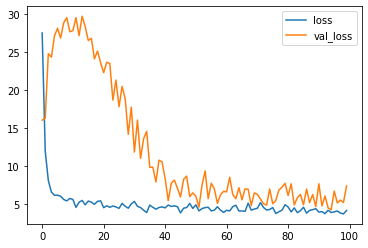

In [11]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=1,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

- **batch normalization 3층 추가**

In [12]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

Epoch 1/100
12/12 [==============================] - 0s 23ms/step - loss: 35.5297 - mae: 35.5297 - val_loss: 38.6792 - val_mae: 38.6792
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 35.1505 - mae: 35.1505 - val_loss: 37.5714 - val_mae: 37.5714
Epoch 3/100
12/12 [==============================] - 0s 11ms/step - loss: 34.7506 - mae: 34.7506 - val_loss: 36.8996 - val_mae: 36.8996
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 34.3140 - mae: 34.3140 - val_loss: 36.3246 - val_mae: 36.3246
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 33.8239 - mae: 33.8239 - val_loss: 35.7647 - val_mae: 35.7647
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 33.2561 - mae: 33.2561 - val_loss: 35.1469 - val_mae: 35.1469
Epoch 7/100
12/12 [==============================] - 0s 8ms/step - loss: 32.5865 - mae: 32.5865 - val_loss: 34.4301 - val_mae: 34.4301
Epoch 8/100
12/12 [==============================] - 

12/12 [==============================] - 0s 7ms/step - loss: 3.3813 - mae: 3.3813 - val_loss: 4.7484 - val_mae: 4.7484
Epoch 63/100
12/12 [==============================] - 0s 7ms/step - loss: 3.4844 - mae: 3.4844 - val_loss: 4.6475 - val_mae: 4.6475
Epoch 64/100
12/12 [==============================] - 0s 7ms/step - loss: 3.5672 - mae: 3.5672 - val_loss: 4.5445 - val_mae: 4.5445
Epoch 65/100
12/12 [==============================] - 0s 7ms/step - loss: 3.6960 - mae: 3.6960 - val_loss: 5.5639 - val_mae: 5.5639
Epoch 66/100
12/12 [==============================] - 0s 7ms/step - loss: 3.6560 - mae: 3.6560 - val_loss: 5.5060 - val_mae: 5.5060
Epoch 67/100
12/12 [==============================] - 0s 7ms/step - loss: 3.8786 - mae: 3.8786 - val_loss: 4.3754 - val_mae: 4.3754
Epoch 68/100
12/12 [==============================] - 0s 7ms/step - loss: 3.8196 - mae: 3.8196 - val_loss: 5.2887 - val_mae: 5.2887
Epoch 69/100
12/12 [==============================] - 0s 7ms/step - loss: 3.8066 - mae: 3

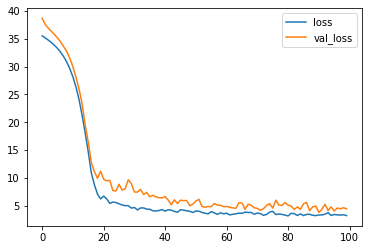

In [13]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=1,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

#### 결과

- 